In [ ]:
!pip install photutils

In [ ]:
import numpy as np
import scipy as sp
import glob
from matplotlib import pyplot as plt
from astropy.io import fits

from astropy.visualization import (
    ImageNormalize,
    AsinhStretch,
    LogStretch,
    LinearStretch,
    SqrtStretch,
    ZScaleInterval,
    MinMaxInterval
)
from astropy.stats import sigma_clipped_stats
from photutils.aperture import CircularAperture, aperture_photometry

In [ ]:
plt.rcParams.update({
    'font.size': 14,
    'font.family': 'serif',
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'figure.figsize': (6, 6),
    'figure.autolayout': True,
    'lines.linewidth': 2.0,
    'lines.markersize': 8,
})

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Master Bias

In [ ]:
bias_files = glob.glob('/content/drive/MyDrive/group 3 Photometry/Bias_Procyon/*.fit')

bias_stack = []
for f in bias_files:
    bias_stack.append(fits.getdata(f))

master_bias = np.median(bias_stack, axis=0)


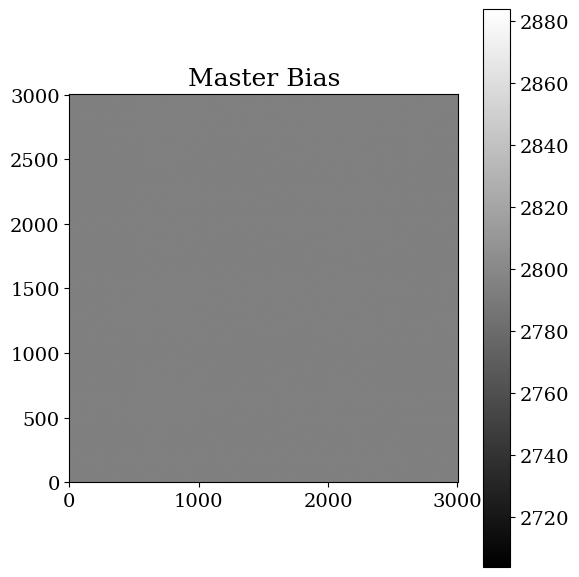

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(master_bias, cmap='gray', origin='lower')
plt.title("Master Bias")
plt.colorbar()
plt.show()


Master Dark

In [ ]:
dark_files = glob.glob('/content/drive/MyDrive/group 3 Photometry/Dark_Procyon/*.fit')

dark_stack = []
for f in dark_files:
    dark_stack.append(fits.getdata(f))

master_dark = np.median(dark_stack, axis=0)


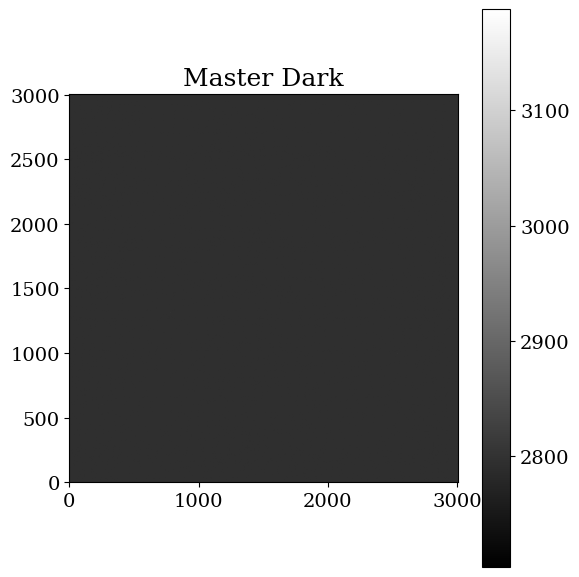

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(master_dark, cmap='gray', origin='lower')
plt.title("Master Dark")
plt.colorbar()
plt.show()

Master Flat

In [ ]:
flat_files = glob.glob('/content/drive/MyDrive/Data/Flat/*.fit')

flat_stack = []
for f in flat_files:
    flat = fits.getdata(f)
    flat_corr = flat - master_bias
    flat_stack.append(flat_corr)

master_flat = np.median(flat_stack, axis=0)

master_flat = master_flat / np.mean(master_flat)


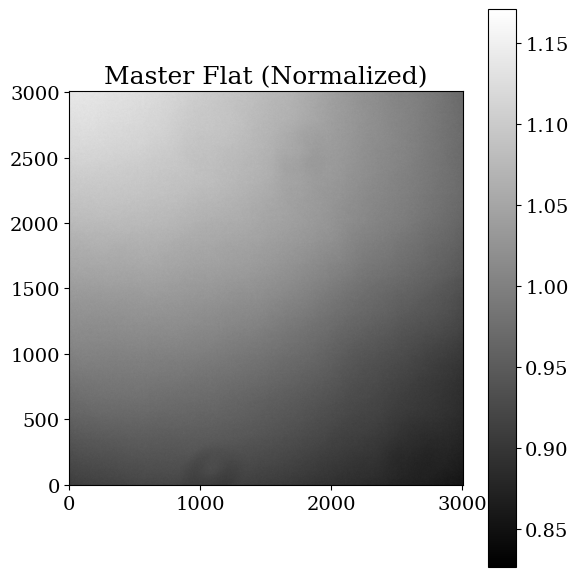

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(master_flat, cmap='gray', origin='lower')
plt.title("Master Flat (Normalized)")
plt.colorbar()
plt.show()

Light calibrate

In [ ]:
hdul = fits.open('/content/drive/MyDrive/group 3 Photometry/Light_Procyon/Light_Procyon_5sec_Bin1_filter-B_-12.6C_gain0_2026-02-09_193014_frame0001.fit')
hdul.info()
hdu = hdul[0]
hdu.header

Filename: /content/drive/MyDrive/group 3 Photometry/Light_Procyon/Light_Procyon_5sec_Bin1_filter-B_-12.6C_gain0_2026-02-09_193014_frame0001.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      34   (3008, 3008)   int16 (rescales to uint16)   


SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 3008 / length of data axis 1                          
NAXIS2  =                 3008 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
BZERO   =                32768 / physical = BZERO + BSCALE*array_value          
BSCALE  =                    1 / physical = BZERO + BSCALE*array_value          
XBINNING=                    1 / Binning factor in width                        
YBINNING=                    1 / Binning factor in height                       
EXPOINUS=              50000

# Procyon Star - Standardized Calibration

Corrected Median: 67.39 Electrons


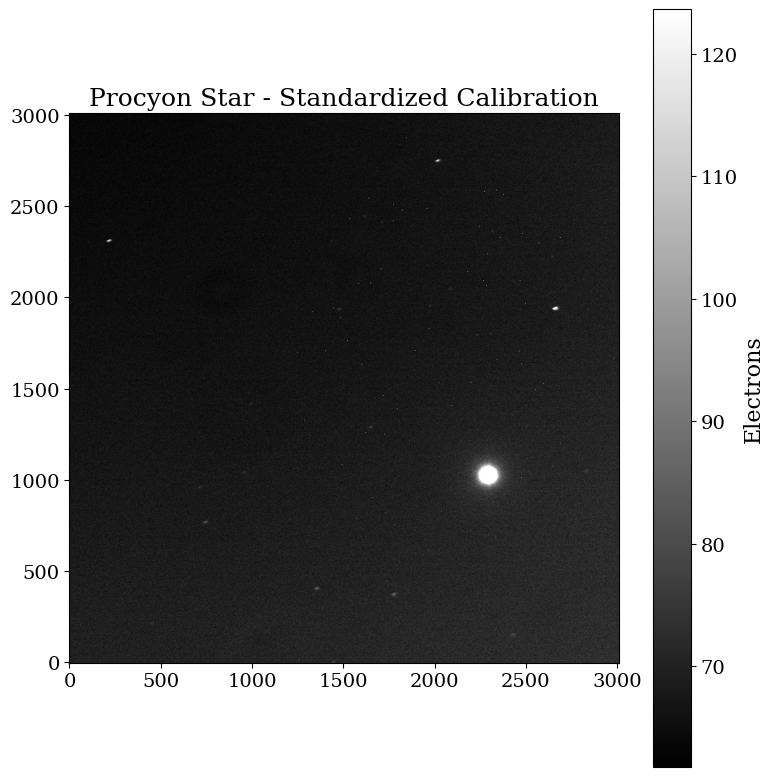

In [ ]:
sci_path = '/content/drive/MyDrive/group 3 Photometry/Light_Procyon/Light_Procyon_5sec_Bin1_filter-B_-12.6C_gain0_2026-02-09_193014_frame0001.fit'
with fits.open(sci_path) as hdul:
    raw_light = hdul[0].data.astype(np.float64)

# Formula: (Raw - Master_Dark) / Master_Flat
calibrated_adu = (raw_light - master_dark ) / master_flat

offset_val = 70
calibrated_adu += offset_val

gain = 0.44
final_calibrated = calibrated_adu * gain

# Verification with Sigma Clipping
from astropy.stats import sigma_clipped_stats
mean, median, std = sigma_clipped_stats(final_calibrated)

print(f"Corrected Median: {median:.2f} Electrons")

plt.figure(figsize=(8, 8))
plt.imshow(final_calibrated, cmap='gray', origin='lower', vmin=median-std, vmax=median+10*std)
plt.title("Procyon Star - Standardized Calibration")
plt.colorbar(label='Electrons')
plt.show()

# Reference Star Instrumental Magnitude





Final Flux: 27218441.53 Electrons
Instrumental Magnitude: -18.59


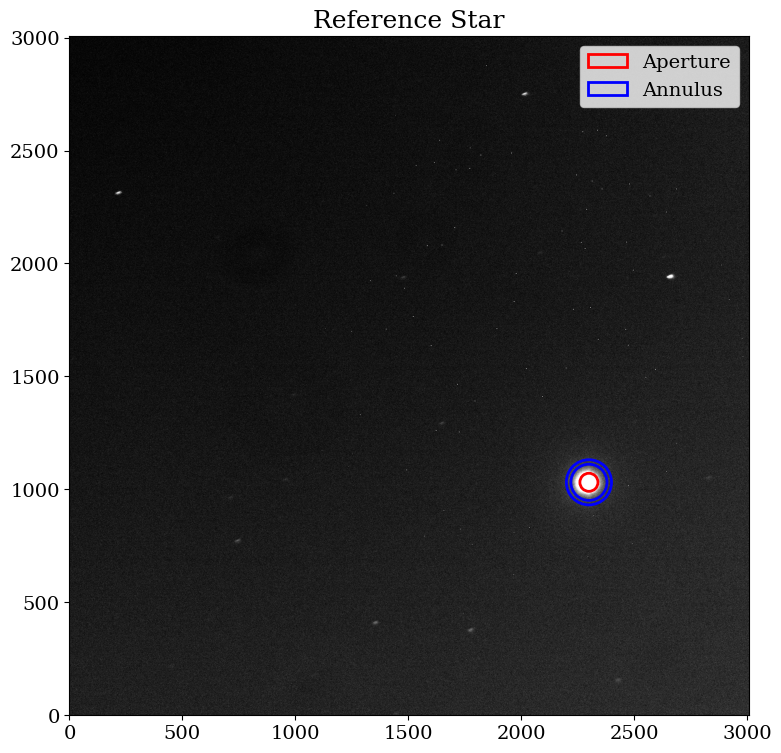

In [ ]:
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry

positions = [(2300, 1031)]

aperture = CircularAperture(positions, r=40)
annulus = CircularAnnulus(positions, r_in=80, r_out=100)

phot_table = aperture_photometry(final_calibrated, aperture)
annulus_table = aperture_photometry(final_calibrated, annulus)

bkg_mean = annulus_table['aperture_sum'] / annulus.area
bkg_total = bkg_mean * aperture.area
final_flux = phot_table['aperture_sum'] - bkg_total

inst_mag = -2.5 * np.log10(final_flux[0])

print(f"Final Flux: {final_flux[0]:.2f} Electrons")
print(f"Instrumental Magnitude: {inst_mag:.2f}")

plt.figure(figsize=(8,8))
plt.imshow(final_calibrated, cmap='gray', origin='lower', vmin=median-std, vmax=median+10*std)
aperture.plot(color='red', lw=2, label='Aperture')
annulus.plot(color='blue', lw=2, label='Annulus')
plt.title("Reference Star")
plt.legend()
plt.show()


In [ ]:
Flux_ref = final_flux[0]
m_ref_inst = inst_mag


# Target Star Instrumental Magnitude

Final Flux: 26611.09 Electrons
Instrumental Magnitude: -11.06


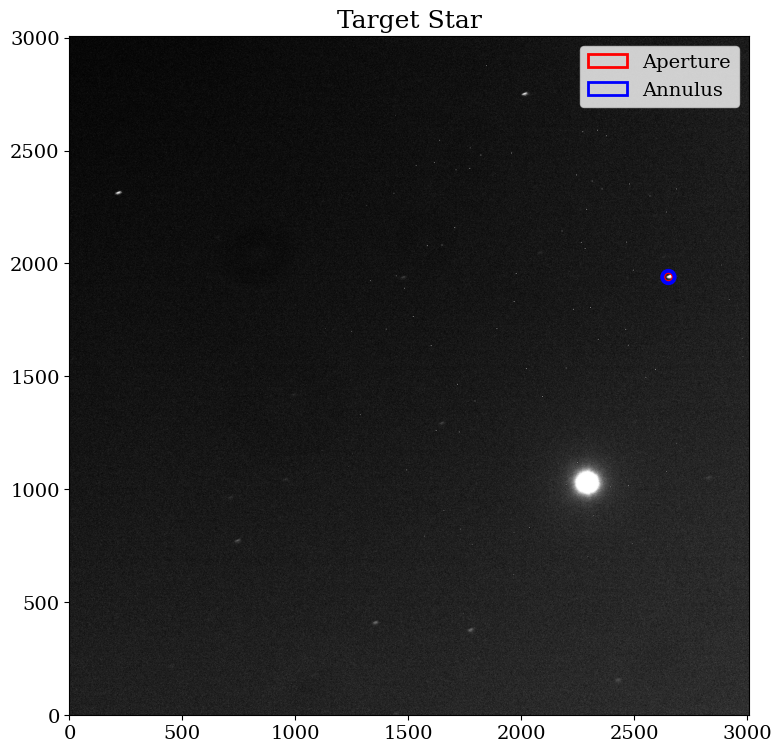

In [ ]:
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry

positions = [(2652,1940)]

aperture = CircularAperture(positions, r=20)
annulus = CircularAnnulus(positions, r_in=25, r_out=30)

phot_table = aperture_photometry(final_calibrated, aperture)
annulus_table = aperture_photometry(final_calibrated, annulus)

bkg_mean = annulus_table['aperture_sum'] / annulus.area
bkg_total = bkg_mean * aperture.area
final_flux = phot_table['aperture_sum'] - bkg_total

inst_mag = -2.5 * np.log10(final_flux[0])

print(f"Final Flux: {final_flux[0]:.2f} Electrons")
print(f"Instrumental Magnitude: {inst_mag:.2f}")

plt.figure(figsize=(8,8))
plt.imshow(final_calibrated, cmap='gray', origin='lower', vmin=median-std, vmax=median+10*std)
aperture.plot(color='red', lw=2, label='Aperture')
annulus.plot(color='blue', lw=2, label='Annulus')
plt.title("Target Star")
plt.legend()
plt.show()
Flux_tar = final_flux[0]

# Differential Results

In [ ]:
Flux_ref = Flux_ref
Flux_tar = Flux_tar

m_ref_inst = -2.5*np.log10(Flux_ref)
m_tar_inst = -2.5*np.log10(Flux_tar)

m_ref_catalog = 0.79

m_target = m_ref_catalog + (m_tar_inst - m_ref_inst)

print("Instrumental mag (Ref) :", m_ref_inst)
print("Instrumental mag (Tar) :", m_tar_inst)
print("Differential (Δm)      :", m_tar_inst - m_ref_inst)
print("Target magnitude       :", m_target)


Instrumental mag (Ref) : -18.60015582726061
Instrumental mag (Tar) : -11.062656527393141
Differential (Δm)      : 7.53749929986747
Target magnitude       : 8.327499299867469


# Curve of Growth

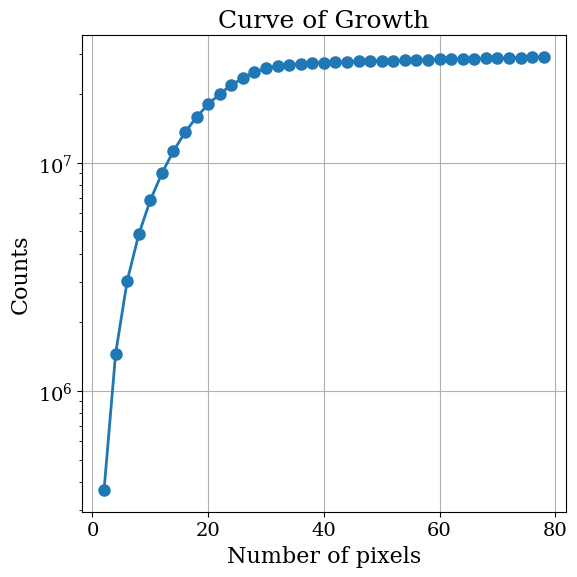

In [ ]:
from photutils.aperture import CircularAperture, aperture_photometry
import numpy as np
import matplotlib.pyplot as plt

#position = [(2300,1040)]
positions = [(2300, 1031)]
radii = np.arange(2,80,2)
fluxes = []
npixels = []

for r in radii:
    ap = CircularAperture(position, r=r)
    phot = aperture_photometry(final_calibrated, ap)

    fluxes.append(phot['aperture_sum'][0])
    npixels.append(r)

plt.figure()
plt.plot(npixels, fluxes, marker='o')
plt.xlabel("Number of pixels")
plt.ylabel("Counts")
plt.title("Curve of Growth")
plt.yscale('log')
plt.grid()
plt.show()


# Signal-to-Noise Ratio (SNR)

In [ ]:
F = Flux_ref
npix = aperture.area          # pixels in aperture
Ssky = bkg_mean            # sky electrons per pixel

SNR = F / np.sqrt(F + npix*Ssky)

sigma_m = 1.0857 / SNR

print("SNR =", SNR)
print("Magnitude uncertainty for reference Star =", sigma_m)

SNR =    aperture_sum  
-----------------
5240.145833165783
Magnitude uncertainty for reference Star =      aperture_sum     
----------------------
0.00020718889026492704


In [ ]:
F = Flux_tar
npix = aperture.area
Ssky = bkg_mean

SNR = F / np.sqrt(F + npix*Ssky)

sigma_m = 1.0857 / SNR

print("SNR =", SNR)
print("Magnitude uncertainty for target star =", sigma_m)

SNR =    aperture_sum  
-----------------
78.81546628083619
Magnitude uncertainty for target star =     aperture_sum    
--------------------
0.013775215084453363


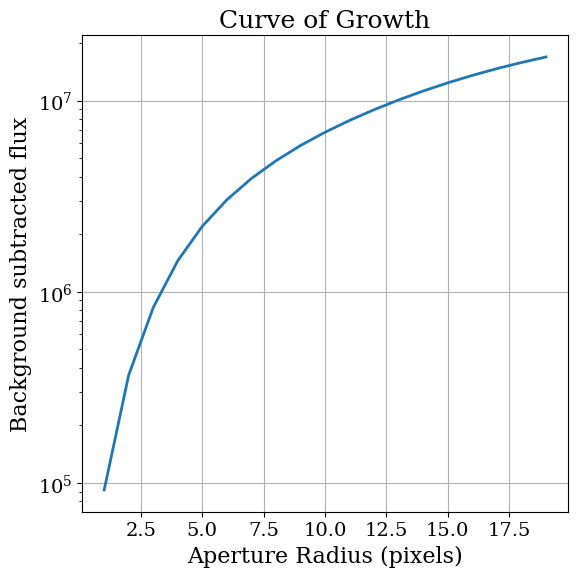

In [ ]:
min_px = 1
max_px = 20

radii = np.arange(min_px, max_px)
star_flux_clean = []

for r in radii:

    aper = CircularAperture(position, r=r)

    raw_sum = aperture_photometry(final_calibrated, aper)['aperture_sum'][0]

    # background subtraction
    clean_sum = raw_sum - (bkg_mean[0] * aper.area)

    star_flux_clean.append(clean_sum)
plt.plot(range(min_px, max_px), star_flux_clean)
plt.xlabel("Aperture Radius (pixels)")
plt.ylabel("Background subtracted flux")
plt.yscale('log')
plt.title("Curve of Growth")
plt.grid(True)
plt.show()